# k-means clustering

In [1]:
import csv
from random import sample
from statistics import mean
from math import sqrt, inf
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Tuple
from matplotlib import pyplot as plt

In [3]:
# Ensure that we have a `data` directory we use to store downloaded data
!mkdir -p data
data_dir: Path = Path('data')

# Downloading the Iris data set
!wget -nc -P data https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

File ‘data/iris.data’ already there; not retrieving.



In [4]:
# The structure of the Iris data set is as follows:
# Sepal Length, Sepal Width, Petal Length, Petal Width, Class
!tail data/iris.data

6.9,3.1,5.1,2.3,Iris-virginica
5.8,2.7,5.1,1.9,Iris-virginica
6.8,3.2,5.9,2.3,Iris-virginica
6.7,3.3,5.7,2.5,Iris-virginica
6.7,3.0,5.2,2.3,Iris-virginica
6.3,2.5,5.0,1.9,Iris-virginica
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica



In [5]:
# Create the Python path pointing to the `iris.data` file
data_path: Path = data_dir / 'iris.data'

In [6]:
# The list in which we store the "petal length" and "sepal width" as vectors (a vector is a list of floats)
data_points: List[List[float]] = []

# Indexes according to the data set description
petal_length_idx: int = 2
sepal_width_idx: int = 1

# Read the `iris.data` file and parse it line-by-line
with open(data_path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for row in reader:
        # Check if the given row is a valid iris data point
        if len(row) == 5:
            label: str = row[-1]
            x1: float = float(row[petal_length_idx])
            x2: float = float(row[sepal_width_idx])
            data_points.append([x1, x2])

In [7]:
len(data_points)

150

In [8]:
data_points[:5]

[[1.4, 3.5], [1.4, 3.0], [1.3, 3.2], [1.5, 3.1], [1.4, 3.6]]

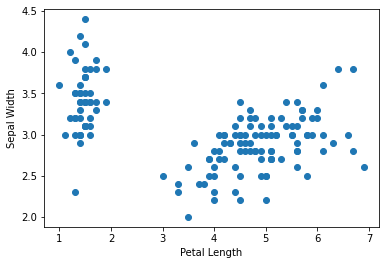

In [9]:
# Plot the `data_points`
plt.scatter([item[0] for item in data_points], [item[1] for item in data_points])
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width');

In [10]:
# Function to compute the Euclidean distance
# See: https://en.wikipedia.org/wiki/Euclidean_distance
def distance(a: List[float], b: List[float]) -> float:
    assert len(a) == len(b)
    return sqrt(sum((a_i - b_i) ** 2 for a_i, b_i in zip(a, b)))

assert distance([1, 2], [1, 2]) == 0
assert distance([1, 2, 3, 4], [5, 6, 7, 8]) == 8

In [11]:
# Function which computes the element-wise average of a list of vectors (a vector is a list of floats)
def vector_mean(xs: List[List[float]]) -> List[float]:
    # Check that all arrays have the same number of dimensions
    for prev, curr in zip(xs, xs[1:]):
        assert len(prev) == len(curr)
    num_items: int = len(xs)
    # Figure out how many dimensions we have to support
    num_dims: int = len(xs[0])
    # Dynamically create a list which contains lists for each dimension
    # to simplify the mean calculation later on
    dim_values: List[List[float]] = [[] for _ in range(num_dims)]
    for x in xs:
        for dim, val in enumerate(x):
            dim_values[dim].append(val)
    # Calculate the mean across the dimensions
    return [mean(item) for item in dim_values]

assert vector_mean([[1], [2], [3]]) == [2]
assert vector_mean([[1, 2], [3, 4], [5, 6]]) == [3, 4]
assert vector_mean([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) == [4, 5, 6]

In [12]:
class KMeans:
    def __init__(self, k: int) -> None:
        self._k: int = k
        self._centroids: Dict[int, List[float]] = defaultdict(list)
        self._clusters: Dict[int, List[List[float]]] = defaultdict(list)

    def train(self, data_points: List[List[float]]) -> None:
        # Pick `k` random samples from the `data_points` and use them as the initial centroids
        centroids: List[List[float]] = sample(data_points, self._k)
        # Initialize the `_centroids` lookup dict with such centroids
        for i, centroid in enumerate(centroids):
            self._centroids[i] = centroid
        # Star the training process
        while True:
            # Starting a new round, removing all previous `cluster` associations (if any)
            self._clusters.clear()            
            # Iterate over all items in the `data_points` and compute their distances to all `centroids`
            item: List[float]
            for item in data_points:
                smallest_distance: float = inf
                closest_centroid_idx: int = None
                # Identify the closest `centroid`
                centroid_idx: int
                centroid: List[float]
                for centroid_idx, centroid in self._centroids.items():
                    current_distance: float = distance(item, centroid)
                    if current_distance < smallest_distance:
                        smallest_distance: float = current_distance
                        closest_centroid_idx: int = centroid_idx
                # Append the current `item` to the `Cluster` whith the nearest `centroid`
                self._clusters[closest_centroid_idx].append(item)
            # The `vector_mean` of all items in the `cluster` should be the `cluster`s new centroid
            old_centroid: List[float]
            centroids_to_update: List[Tuple[int, List[float]]] = []
            for old_centroid_idx, old_centroid in self._centroids.items():
                items: List[List[float]] = self._clusters[old_centroid_idx]
                new_centroid: List[float] = vector_mean(items)
                if new_centroid != old_centroid:
                    centroids_to_update.append((old_centroid_idx, new_centroid))
            # Update centroids if they changed
            if len(centroids_to_update):
                idx: int
                centroid: List[float]
                for idx, centroid in centroids_to_update:
                    self._centroids[idx] = centroid
            # If nothing changed, we're done
            else:
                break
    
    @property
    def centroids(self) -> Dict[int, List[float]]:
        return self._centroids
    
    @property
    def clusters(self) -> Dict[int, List[List[float]]]:
        return self._clusters

In [13]:
# Create a new KMeans instance and train it
km: KMeans = KMeans(2)
km.train(data_points)

print(f'The clusters centroids are: {list(km.centroids.values())}')
print(f'The number of elements in each cluster are: {[len(items) for items in km.clusters.values()]}')

The clusters centroids are: [[1.4941176470588236, 3.4], [4.925252525252525, 2.875757575757576]]
The number of elements in each cluster are: [51, 99]


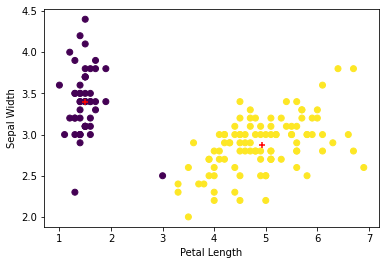

In [14]:
# Plot the `clusters` and their `centroids`
# Gather all the necessary data to plot the `clusters`
xs: List[float] = []
ys: List[float] = []
cs: List[int] = []
for cluster_idx, items in km.clusters.items():
    for item in items:
        cs.append(cluster_idx)
        xs.append(item[0])
        ys.append(item[1])

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xs, ys, c=cs)

# Add the centroids
for c in km.centroids.values():
    ax.scatter(c[0], c[1], c='red', marker='+')

# Set labels
ax.set_xlabel('Petal Length')
ax.set_ylabel('Sepal Width');

In [15]:
# Function which quantifies how far apart two values are
# We'll use it to calculate errors later on
def squared_error(a: float, b: float) -> float:
    return (a - b) ** 2

assert squared_error(2, 2) == 0
assert squared_error(1, 2) == 1
assert squared_error(1, 10) == 81

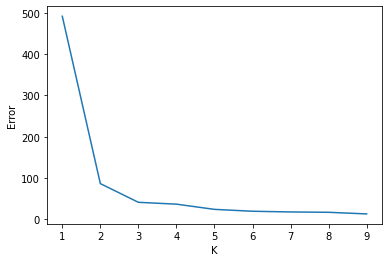

In [16]:
# Create an "Elbow chart" to find the "best" `k`
# See: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

# Lists to record the `k` values and the computed `error` sums
# which are used for plotting later on
ks: List[int] = []
error_sums: List[float] = []

# Create clusterings for the range of `k` values
for k in range(1, 10):
    # Create and train a new KMeans instance for the current `k`
    km: KMeans = KMeans(k)
    km.train(data_points)
    # List to keep track of the individual KMean errors
    errors: List[float] = []
    # Iterate over all `clusters` and extract their `centroid_idx`s and `items`
    centroid_idx: List[float]
    items: List[List[float]]
    for centroid_idx, items in km.clusters.items():
        # Lookup `centroid` coordinates based on its index
        centroid: List[float] = km.centroids[centroid_idx]
        # Iterate over each `item` in the cluster
        item: List[float]
        for item in items:
            # Calculate how far the current `cluster`s `item` is from the `centroid`
            dist: float = distance(centroid, item)
            # The closer the `item` in question, the better (less error)
            # (the closest one can be is `0`)
            error: float = squared_error(dist, 0)
            # Record the `error` value
            errors.append(error)
    # Append the current `k` and the sum of all `errors`
    ks.append(k)
    error_sums.append(sum(errors))

# Plot the `k` and error values to see which `k` is "best"
plt.plot(ks, error_sums)
plt.xlabel('K')
plt.ylabel('Error');